# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

2024-05-14 19:39:58.782004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 19:39:58.782118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 19:39:58.919885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path='/kaggle/input/fer2013/train'
test_path='/kaggle/input/fer2013/test'
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


## train data

In [3]:
import os
import pandas as pd

# Get list of all files in dataset folder and subfolders
file_paths = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        file_paths.append(os.path.join(root, file))

# Extract class information from folder structure
classes = [os.path.basename(os.path.dirname(path)) for path in file_paths]

# Create DataFrame
df_train = pd.DataFrame({"path": file_paths, "class": classes})

# Display DataFrame
print(df_train.head())

                                                path     class
0  /kaggle/input/fer2013/train/surprise/Training_...  surprise
1  /kaggle/input/fer2013/train/surprise/Training_...  surprise
2  /kaggle/input/fer2013/train/surprise/Training_...  surprise
3  /kaggle/input/fer2013/train/surprise/Training_...  surprise
4  /kaggle/input/fer2013/train/surprise/Training_...  surprise


## test data

In [4]:

# Get list of all files in dataset folder and subfolders
file_paths = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        file_paths.append(os.path.join(root, file))

# Extract class information from folder structure
classes = [os.path.basename(os.path.dirname(path)) for path in file_paths]

# Create DataFrame
df_test = pd.DataFrame({"path": file_paths, "class": classes})

# Display DataFrame
print(df_test.head())

                                                path     class
0  /kaggle/input/fer2013/train/surprise/Training_...  surprise
1  /kaggle/input/fer2013/train/surprise/Training_...  surprise
2  /kaggle/input/fer2013/train/surprise/Training_...  surprise
3  /kaggle/input/fer2013/train/surprise/Training_...  surprise
4  /kaggle/input/fer2013/train/surprise/Training_...  surprise


In [5]:
print("category",df_train['class'].unique())
print("category",df_test['class'].unique())

category ['surprise' 'fear' 'angry' 'neutral' 'sad' 'disgust' 'happy']
category ['surprise' 'fear' 'angry' 'neutral' 'sad' 'disgust' 'happy']


In [6]:
# prepare dataset
IMG_DIM = 128


def imread(img_path):
    img = cv2.imread(img_path)
    img = img.astype('float32')/255.0
    img = cv2.resize(img, (IMG_DIM, IMG_DIM))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()
   


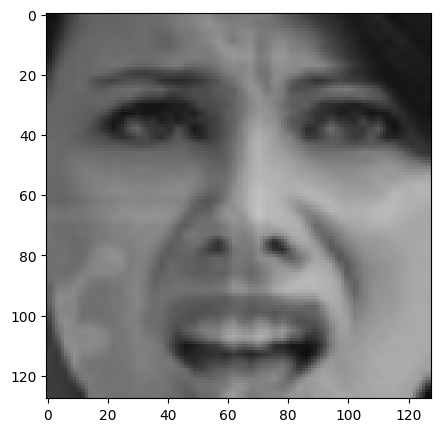

In [7]:
image_path='/kaggle/input/fer2013/train/disgust/Training_11652168.jpg'
img=imread(image_path)
imshow(img,figsize=(5, 5))

## shuffle train df

In [8]:
import pandas as pd

# Assuming df is your DataFrame
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Display shuffled DataFrame
df_train.head()

path    class
0  /kaggle/input/fer2013/train/fear/Training_9391...     fear
1  /kaggle/input/fer2013/train/neutral/Training_7...  neutral
2  /kaggle/input/fer2013/train/happy/Training_770...    happy
3  /kaggle/input/fer2013/train/fear/Training_2440...     fear
4  /kaggle/input/fer2013/train/happy/Training_773...    happy

## shuffle test df

In [9]:
import pandas as pd

# Assuming df is your DataFrame
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Display shuffled DataFrame
df_test.head()

path    class
0  /kaggle/input/fer2013/train/fear/Training_9391...     fear
1  /kaggle/input/fer2013/train/neutral/Training_7...  neutral
2  /kaggle/input/fer2013/train/happy/Training_770...    happy
3  /kaggle/input/fer2013/train/fear/Training_2440...     fear
4  /kaggle/input/fer2013/train/happy/Training_773...    happy

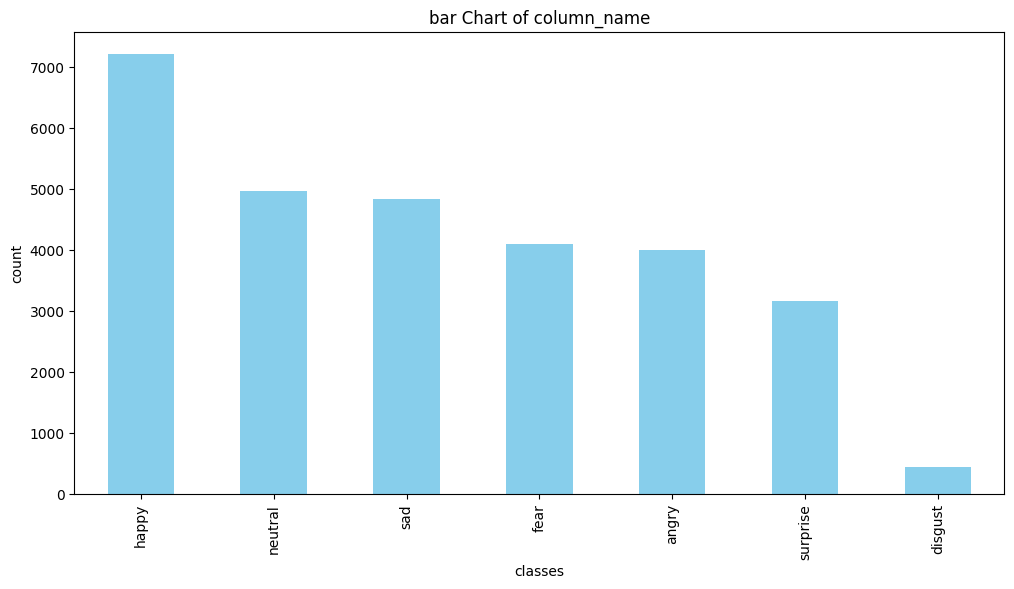

In [10]:
value_counts = df_train['class'].value_counts()

# plotting 
plt.figure(figsize=(12, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('classes')
plt.ylabel('count')
plt.title('bar Chart of column_name')
plt.show()

happy is the largest category

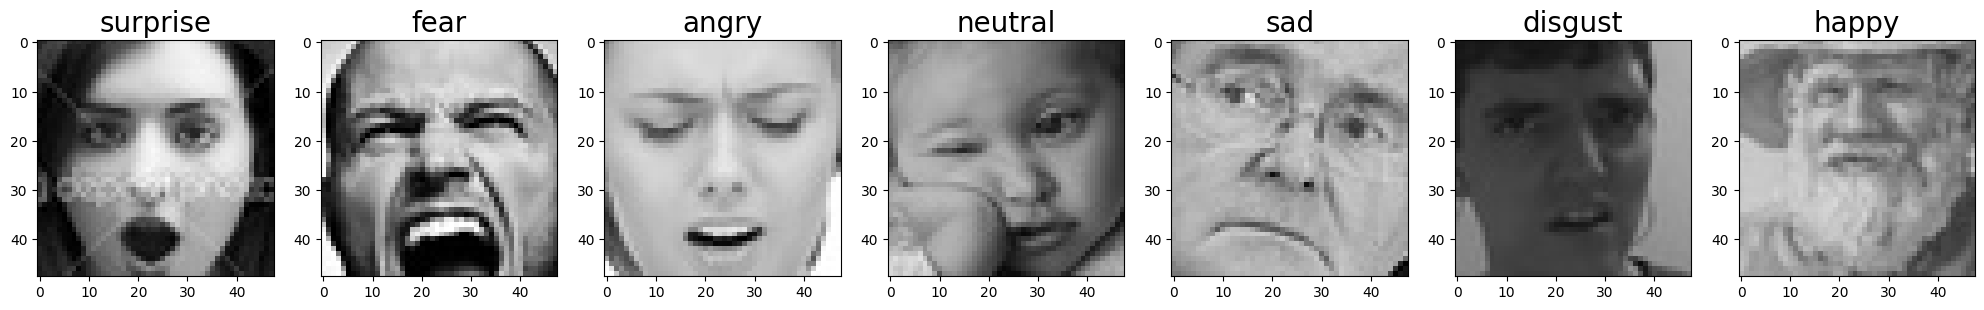

In [11]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
url = '/kaggle/input/fer2013/train/'

for directory in os.listdir(url):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(url + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(url + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

##  preprocessing train 

In [12]:
img_shape = 224
batch_size = 64

train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,        # normalization
        # Data Augmentation
        rotation_range=10,   #rotate 10 deg
        zoom_range=0.2,      #zoom
        width_shift_range=0.1,   
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


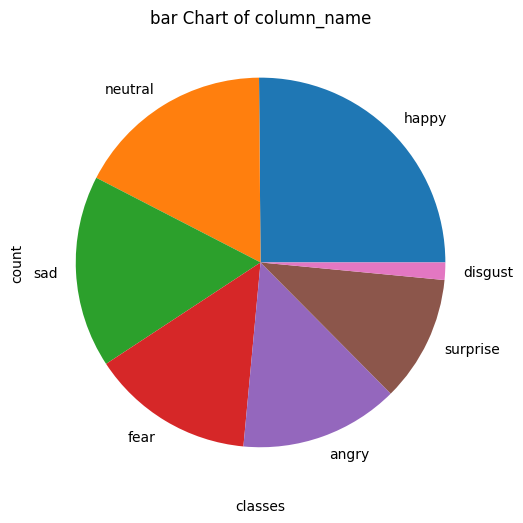

In [13]:
value_counts = df_train['class'].value_counts()

# plotting 
plt.figure(figsize=(12, 6))
value_counts.plot(kind='pie')
plt.xlabel('classes')
plt.ylabel('count')
plt.title('bar Chart of column_name')
plt.show()

## ResNet  Transfer MODEL  

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import ResNet50V2

# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

ResNet50V2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [15]:
# freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [16]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [17]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()

In [18]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 16,352,256 (62.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [42]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"


Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 6, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [43]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=60, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 339s 746ms/step - accuracy: 0.5658 - loss: 1.2085 - precision: 0.7459 - recall: 0.3606 - val_accuracy: 0.6124 - val_loss: 1.0896 - val_precision: 0.7864 - val_recall: 0.4176 - learning_rate: 2.0000e-04
Epoch 2/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5938 - loss: 1.1378 - precision: 0.6316 - recall: 0.3750 - val_accuracy: 1.0000 - val_loss: 0.3063 - val_precision: 1.0000 - val_recall: 0.8000 - learning_rate: 2.0000e-04
Epoch 3/60


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 337s 741ms/step - accuracy: 0.5931 - loss: 1.1299 - precision: 0.7570 - recall: 0.4078 - val_accuracy: 0.6200 - val_loss: 1.0200 - val_precision: 0.7806 - val_recall: 0.4580 - learning_rate: 2.0000e-04
Epoch 4/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.6094 - loss: 1.1581 - precision: 0.7105 - recall: 0.4219
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 100us/step - accuracy: 0.6094 - loss: 1.1581 - precision: 0.7105 - recall: 0.4219 - val_accuracy: 0.9000 - val_loss: 0.5401 - val_precision: 1.0000 - val_recall: 0.6000 - learning_rate: 2.0000e-04
Epoch 5/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 339s 745ms/step - accuracy: 0.6188 - loss: 1.0612 - precision: 0.7733 - recall: 0.4450 - val_accuracy: 0.6338 - val_loss: 0.9874 - val_precision: 0.7839 - val_recall: 0.4692 - learning_rate: 4.0000e-05
Epoch 6/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.6406 - loss: 1.0344 - prec

In [44]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.5176 - loss: 1.2820 - precision: 0.6849 - recall: 0.3323
Test Loss:     1.08756
Test Accuracy: 61.33%


In [50]:
loss = ResNet50V2_history.history["loss"]
val_loss = ResNet50V2_history.history["val_loss"]
accuracy = ResNet50V2_history.history["accuracy"]
val_accuracy = ResNet50V2_history.history["val_accuracy"]

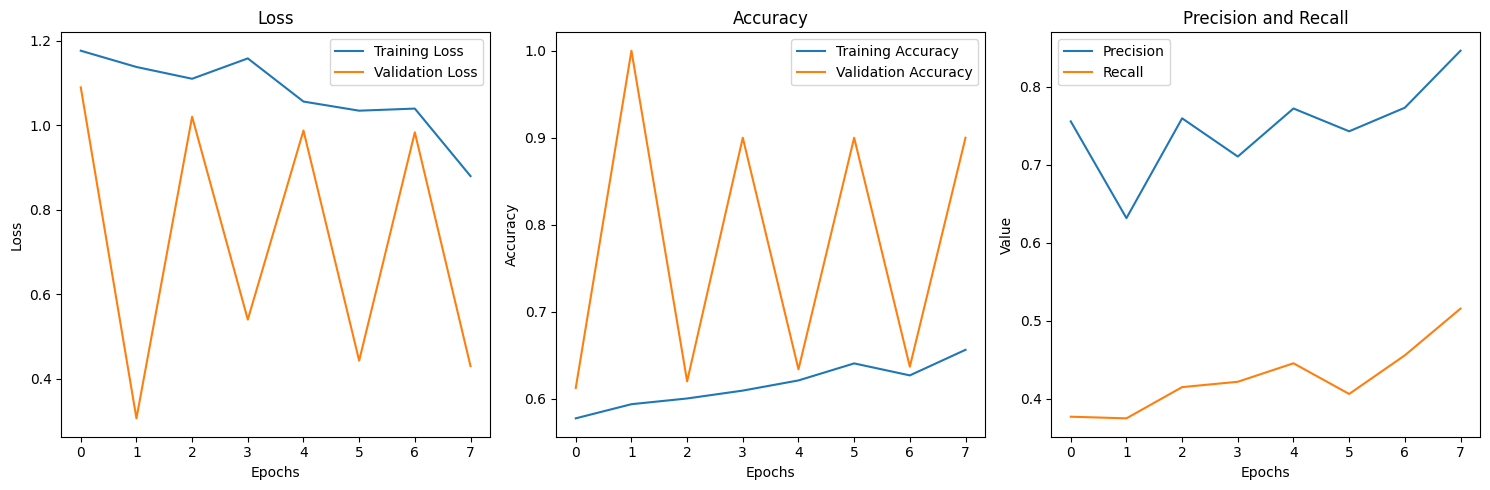

In [51]:

loss = ResNet50V2_history.history["loss"]
val_loss = ResNet50V2_history.history["val_loss"]
accuracy = ResNet50V2_history.history["accuracy"]
val_accuracy = ResNet50V2_history.history["val_accuracy"]

precision = ResNet50V2_history.history["precision"]
recall = ResNet50V2_history.history["recall"]

epochs = range(len(ResNet50V2_history.history["loss"]))
plt.figure(figsize=(15,5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot precision and recall
plt.subplot(1, 3, 3)
plt.plot(epochs, precision, label="Precision")
plt.plot(epochs, recall, label="Recall")
plt.title("Precision and Recall")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()




In [52]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choose highest probalbilty class 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step


In [53]:
history = ResNet50V2_history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 65.62%
Final Precision       : 84.62%
Final Recall          : 51.56%
Final Validation Loss : 0.4299
Final F1 Score        : 0.641


## prediction

In [54]:
class_indices = test_data.class_indices
Emotion_Classes = [key for key in class_indices.keys()]
print(Emotion_Classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [55]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

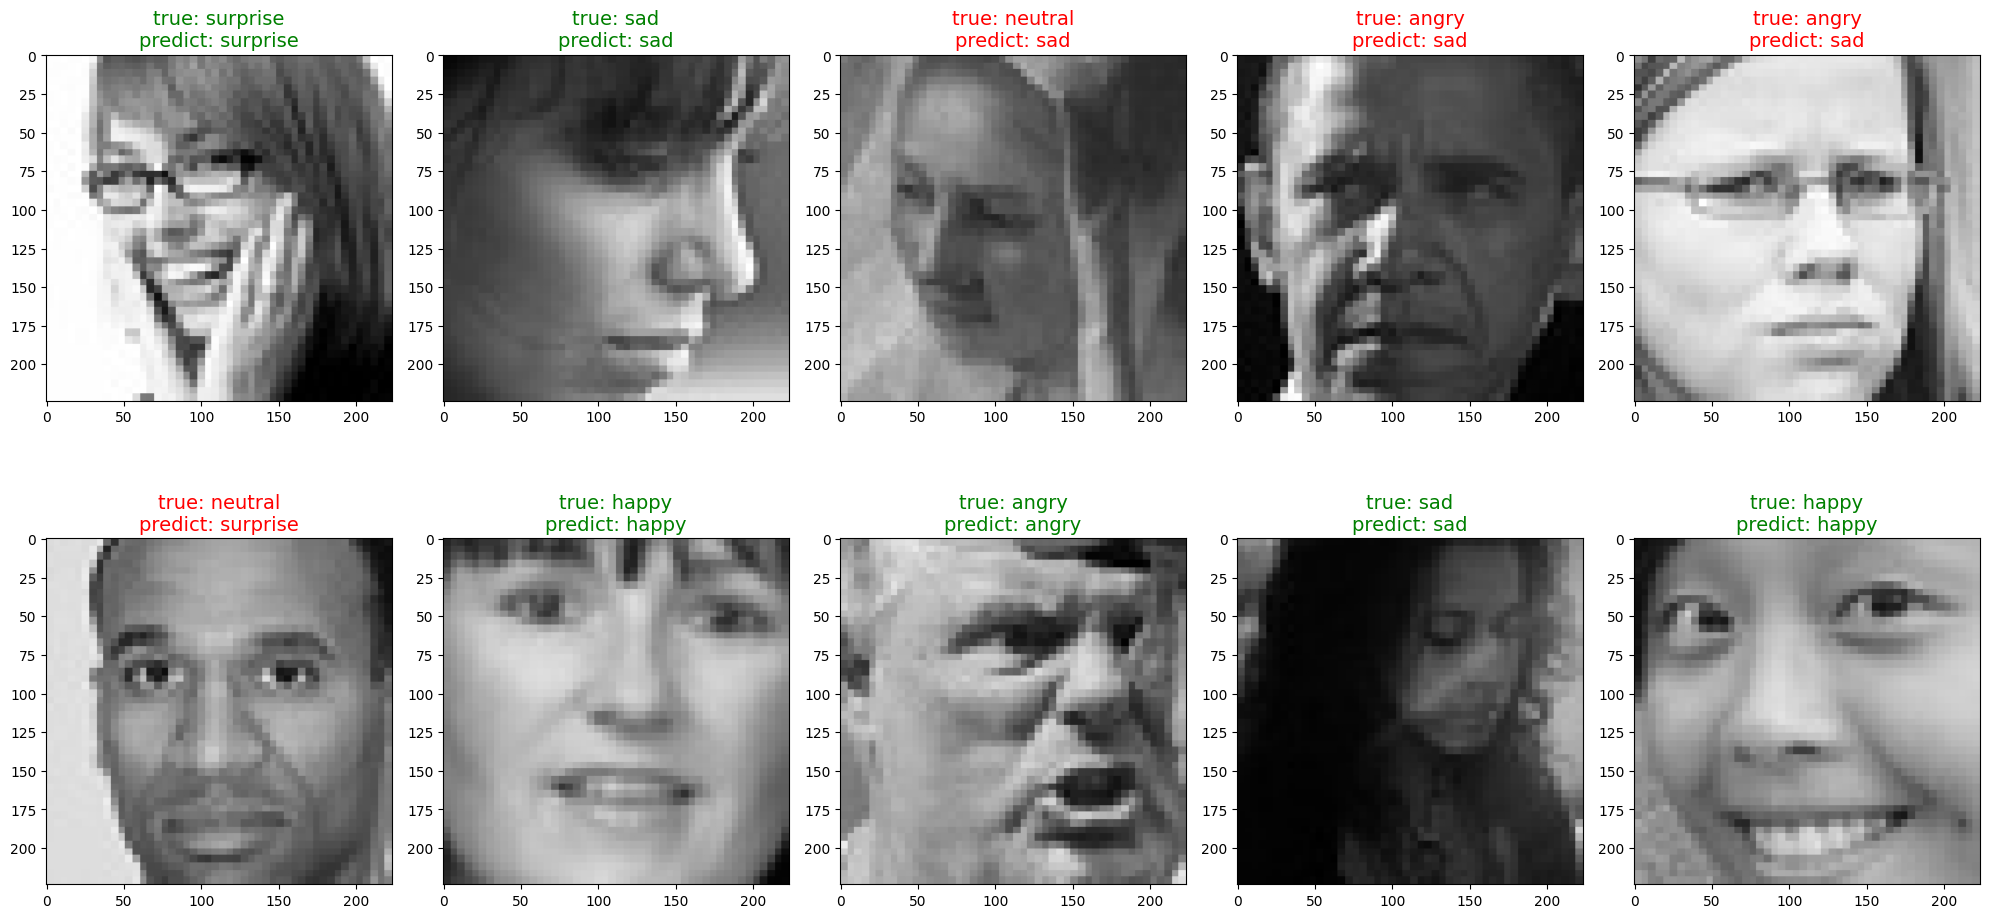

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Sample data
# test_generator --> contains your image data
# batch_size --> size of the batch
# emotion_Classes --> list of emotion classes

# random select a batch and 10 images from it
random_batch = np.random.randint(0, len(test_generator) - 1)
random_img_index = np.random.choice(batch_size, size=10, replace=False)

#subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))


for i, ax in enumerate(axes.flat):
    #random image from the selected batch
    random_img = test_generator[random_batch][0][random_img_index[i]]
    
    # resize the image to 224x224 
    random_img_resized = resize(random_img, (224, 224), anti_aliasing=True)

    #  true label of the image
    img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]])
    
    # Model's prediction
    model_prediction = np.argmax(ResNet50V2_Model.predict(random_img_resized.reshape(1, 224, 224, 3), verbose=0))

    ax.imshow(random_img_resized)

    # Set title with true label, model prediction, and color
    color = "green" if Emotion_Classes[img_label] == Emotion_Classes[model_prediction] else "red"
    ax.set_title(f"true: {Emotion_Classes[img_label]}\npredict: {Emotion_Classes[model_prediction]}", color=color, fontsize=14)

plt.tight_layout()
plt.show()


# try vgg16


In [40]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))

# Add  custom classifier on top of the VGG16 base
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(7, activation='softmax')  # Assuming 7 classes
])

# Freeze the base VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
checkpoint = ModelCheckpoint('vgg16_model.h5.keras', save_best_only=True)
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    callbacks=[checkpoint]
)


Epoch 1/10


2024-05-14 20:31:00.974965: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-14 20:31:01.401001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.87759, expected 3.06898
2024-05-14 20:31:01.401054: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.47516, expected 5.66656
2024-05-14 20:31:01.401071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.23991, expected 5.43131
2024-05-14 20:31:01.401082: E external/local_xla/xla/service/gpu/buffer_compar

  1/449 ━━━━━━━━━━━━━━━━━━━━ 4:51:47 39s/step - accuracy: 0.1406 - loss: 2.1263

W0000 00:00:1715718690.961859     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


244/449 ━━━━━━━━━━━━━━━━━━━━ 2:25 707ms/step - accuracy: 0.3086 - loss: 4.8099

2024-05-14 20:34:24.757598: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 1.69967, expected 1.40412
2024-05-14 20:34:24.757647: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 1.52722, expected 1.23167
2024-05-14 20:34:24.757942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.12984, expected 2.53825
2024-05-14 20:34:24.757988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.82583, expected 4.23423
2024-05-14 20:34:24.758004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.45615, expected 3.86456
2024-05-14 20:34:24.758025: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.48578, expected 3.89419
2024-05-14 20:34:24.758037: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.06198, expected 3.47038
2024-05-14 20:34:24.758050: E e

246/449 ━━━━━━━━━━━━━━━━━━━━ 2:37 774ms/step - accuracy: 0.3091 - loss: 4.7914

W0000 00:00:1715718880.528495     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.3444 - loss: 3.6394

W0000 00:00:1715719020.700099     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-14 20:37:15.926518: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-05-14 20:37:15.926580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-05-14 20:37:15.926597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-05-14 20:37:15.926615: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-05-14 20:37:15.926626: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.6813, expected 4.06503
2024-05-14 20:37:15.926637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.79963, expected 4.18336
2024-05-14 20:37:15.926647: E external/local_xla/xla/service/g

449/449 ━━━━━━━━━━━━━━━━━━━━ 391s 786ms/step - accuracy: 0.3445 - loss: 3.6359 - val_accuracy: 0.4770 - val_loss: 70.8502
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 338s 741ms/step - accuracy: 0.4716 - loss: 1.3904 - val_accuracy: 0.4838 - val_loss: 69.6543
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 340s 747ms/step - accuracy: 0.4965 - loss: 1.3218 - val_accuracy: 0.5124 - val_loss: 78.3339
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 336s 737ms/step - accuracy: 0.5112 - loss: 1.2912 - val_accuracy: 0.5293 - val_loss: 74.3098
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 338s 742ms/step - accuracy: 0.5136 - loss: 1.2809 - val_accuracy: 0.5280 - val_loss: 60.7958
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 337s 739ms/step - accuracy: 0.5240 - loss: 1.2514 - val_accuracy: 0.5149 - val_loss: 56.7253
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 340s 744ms/step - accuracy: 0.5255 - loss: 1.2420 - val_accuracy: 0.5297 - val_loss: 66.9031
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 345s 758ms/step - accuracy: 0.5339 - los

## Music Recommendation

In [59]:
music_path='/kaggle/input/spotify-music-data-to-identify-the-moods/data_moods.csv'

In [60]:
music_data=pd.read_csv(music_path)

In [61]:
music_data.head(5)

name                        album  \
0                                         1999                         1999   
1                                           23                           23   
2                                     9 Crimes                            9   
3                               99 Luftballons               99 Luftballons   
4  A Boy Brushed Red Living In Black And White  They're Only Chasing Safety   

           artist                      id release_date  popularity  length  \
0          Prince  2H7PHVdQ3mXqEHXcvclTB0   1982-10-27          68  379266   
1  Blonde Redhead  4HIwL9ii9CcXpTOTzMq0MP   2007-04-16          43  318800   
2     Damien Rice  5GZEeowhvSieFDiR8fQ2im   2006-11-06          60  217946   
3            Nena  6HA97v4wEGQ5TUClRM0XLc   1984-08-21           2  233000   
4       Underoath  47IWLfIKOKhFnz1FUEUIkE   2004-01-01          60  268000   

   danceability  acousticness  energy  instrumentalness  liveness  valence  \
0         0.866       0.13700   0.730          0.000000    0.0843    0.625   
1         0.381       0.01890   0.832          0.196000    0.1530    0.166   
2         0.346       0.91300   0.139          0.000077    0.0934    0.116   
3         0.466       0.08900   0.438          0.000006    0.1130    0.587   
4         0.419       0.00171   0.932          0.000000    0.1370    0.445   

   loudness  speechiness    tempo  key  time_signature       mood  
0    -8.201       0.0767  118.523    5               4      Happy  
1    -5.069       0.0492  120.255    8               4        Sad  
2   -15.326       0.0321  136.168    0               4        Sad  
3   -12.858       0.0608  193.100    4               4      Happy  
4    -3.604       0.1060  169.881    1               4  Energetic

In [62]:
music_data['mood'].unique()

array(['Happy', 'Sad', 'Energetic', 'Calm'], dtype=object)

In [64]:
music_df=music_data[['name','artist','mood']]


In [69]:
Play = music_df[music_df['mood'] =='Calm' ]

Play = Play[:3].reset_index(drop=True)
display(Play)

name              artist  mood
0  A Burden to Bear  Emmanuelle Rimbaud  Calm
1        A La Plage         Ron Adelaar  Calm
2       Adjustments        Josie Mehlin  Calm

In [66]:
def Recommendation_playlist(pred_class):
 
 #surprise' 'fear' 'angry' 'neutral' 'sad' 'disgust' 'happy'
 #Sad  Calm Energetic  Happy 
    if( pred_class=='disgust' or pred_class=='surprise'):
        Play = music_df[music_df['mood'] =='Energetic']
        Play = Play[:5].reset_index(drop=True)
        display(Play)
        
    if( pred_class=='fear' or pred_class=='angry'):
        Play = music_df[music_df['mood'] =='Calm']
        Play = Play[:5].reset_index(drop=True)
        display(Play)
    
    if( pred_class=='neutral' or pred_class=='happy'):
        Play = music_df[music_df['mood'] =='Happy']
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='sad'):
        Play = music_df[music_df['mood'] =='Sad']
        Play = Play[:5].reset_index(drop=True)
        display(Play)


In [70]:
# Example Testing
Recommendation_playlist("fear")

name              artist  mood
0  A Burden to Bear  Emmanuelle Rimbaud  Calm
1        A La Plage         Ron Adelaar  Calm
2       Adjustments        Josie Mehlin  Calm
3            Adrift         Cooper Sams  Calm
4    After The Rain          Comet Blue  Calm

# predict images

In [108]:
# Downloading OpenCV haarcascade frontalface Detection
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml") 

--2024-05-15 00:02:49--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: 'haarcascade_frontalface_default.xml.1'

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2024-05-15 00:02:49 (27.7 MB/s) - 'haarcascade_frontalface_default.xml.1' saved [930127/930127]



In [77]:
# import cv2
# import numpy as np

# # Load the pre-trained face detection model
# net = cv2.dnn.readNetFromTensorflow('/kaggle/input/cvfiles/opencv_face_detector_uint8.pb', '/kaggle/input/cvfiles/opencv_face_detector.pbtxt')

# # Load an image
# image = cv2.imread('/kaggle/input/try-predict/sad.jpeg')

# # Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Detect faces in the image
# blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], False, False)
# net.setInput(blob)
# detections = net.forward()

# # Draw rectangles around detected faces
# for i in range(detections.shape[2]):
#     confidence = detections[0, 0, i, 2]
#     if confidence > 0.5:  # Confidence threshold
#         box = detections[0, 0, i, 3:7] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
#         (startX, startY, endX, endY) = box.astype("int")
#         cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# # Display the image with the detected faces
# cv2.imshow("Output", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# # 

In [79]:
import cv2
import matplotlib.pyplot as plt

def predict_processing(filename, img_shape = 48):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [85]:
def pred_and_plot(filename, class_names, size):

    # Import the target image and preprocess it
    Random_Img = predict_processing(filename, size)

    # Make a prediction
    Model_Prediction = np.argmax(ResNet50V2_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    pred_class = class_names[Model_Prediction]
    print("Sentiment Identified as: ", pred_class)
    image = cv2.imread(filename)

    # Convert the image from BGR to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis numbers
    plt.show()
   
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()
    print()
    print("*" * 8, "Recommended Music", "*" * 8)
    print()
    Recommendation_playlist(pred_class)

Sentiment Identified as:  sad


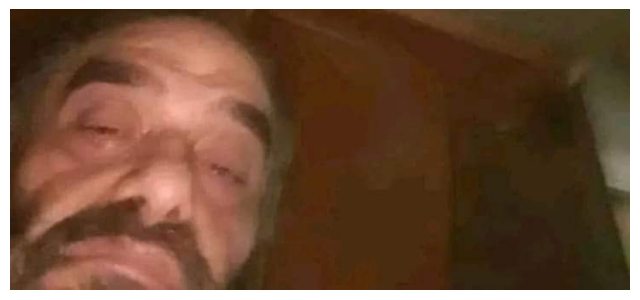

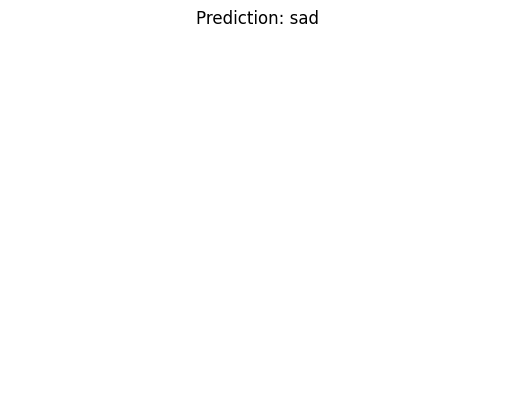


******** Recommended Music ********



name                    artist mood
0           23            Blonde Redhead  Sad
1     9 Crimes               Damien Rice  Sad
2  Algo Rhythm  One Sentence. Supervisor  Sad
3       Alison                  Slowdive  Sad
4   All I Want                  Kodaline  Sad

In [86]:
pred_and_plot("/kaggle/input/try-predict/sad.jpeg", Emotion_Classes, 224)

No Faces Detected
Sentiment Identified as:  happy


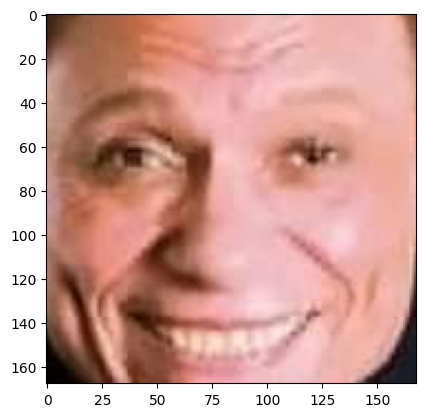

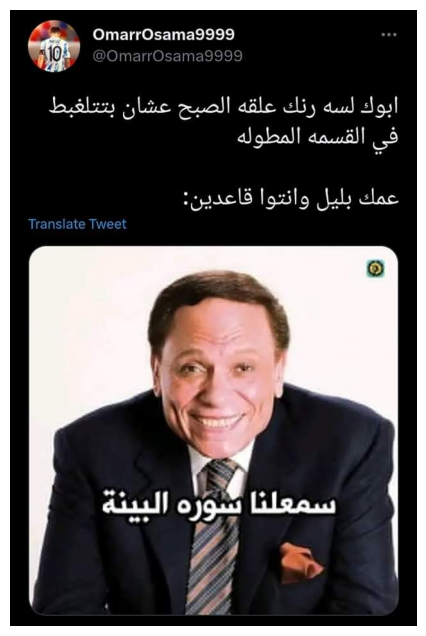

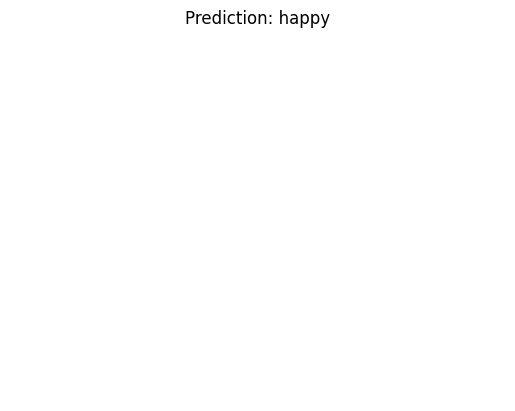


******** Recommended Music ********



name            artist   mood
0                                               1999            Prince  Happy
1                                     99 Luftballons              Nena  Happy
2  A Little Less Conversation - JXL Radio Edit Remix     Elvis Presley  Happy
3                                             Africa              TOTO  Happy
4  All or Nothing (feat. Axel Ehnström) - Deluxe Mix  Lost Frequencies  Happy

In [87]:
pred_and_plot("/kaggle/input/try-predict/happy.jpeg", Emotion_Classes, 224)

Sentiment Identified as:  angry


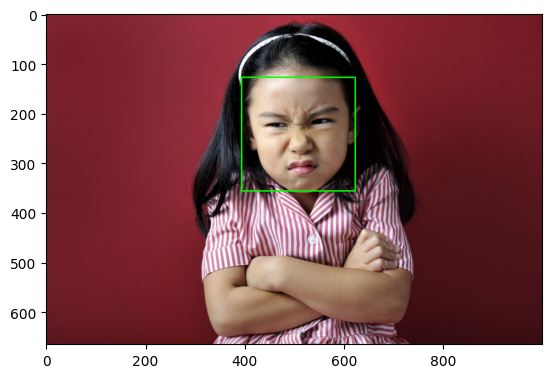

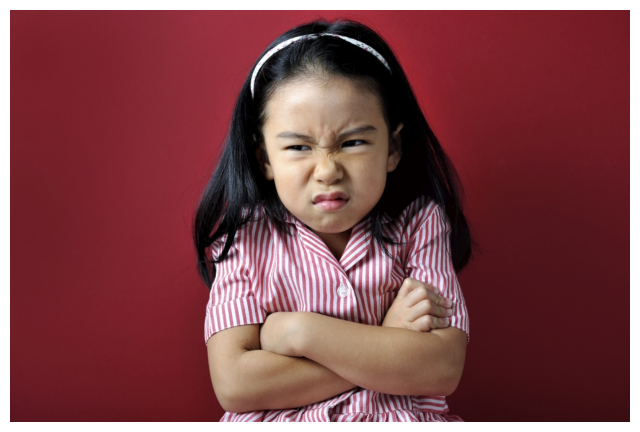

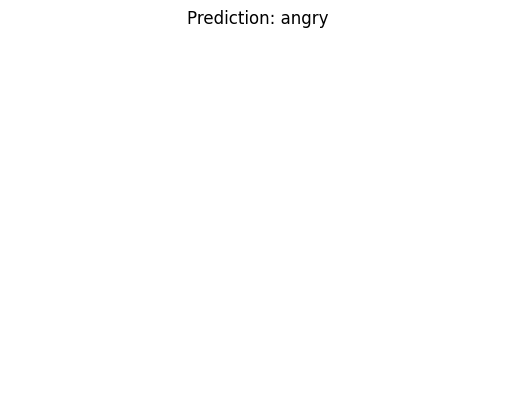


******** Recommended Music ********



name              artist  mood
0  A Burden to Bear  Emmanuelle Rimbaud  Calm
1        A La Plage         Ron Adelaar  Calm
2       Adjustments        Josie Mehlin  Calm
3            Adrift         Cooper Sams  Calm
4    After The Rain          Comet Blue  Calm

In [94]:
pred_and_plot("/kaggle/input/final-predict/angry face.jpg", Emotion_Classes, 224)

Sentiment Identified as:  sad


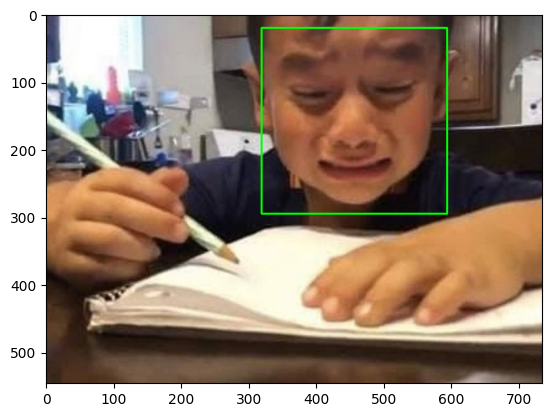

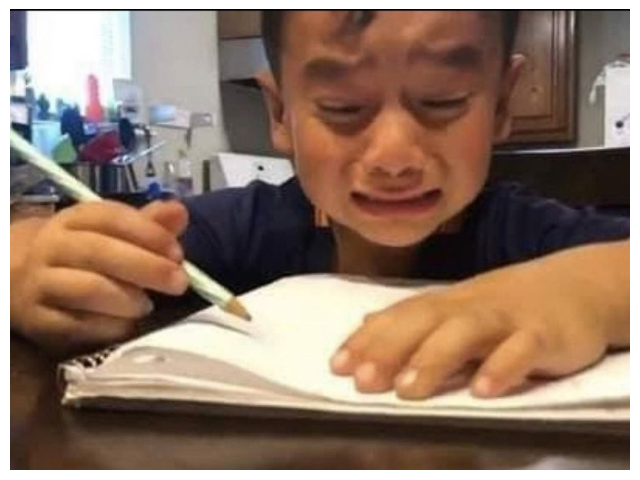

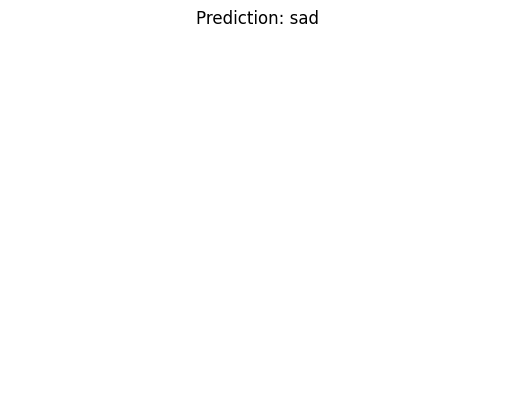


******** Recommended Music ********



name                    artist mood
0           23            Blonde Redhead  Sad
1     9 Crimes               Damien Rice  Sad
2  Algo Rhythm  One Sentence. Supervisor  Sad
3       Alison                  Slowdive  Sad
4   All I Want                  Kodaline  Sad

In [98]:
pred_and_plot("/kaggle/input/final-predict/download (3).jpeg", Emotion_Classes, 224)

No Faces Detected
Sentiment Identified as:  surprise


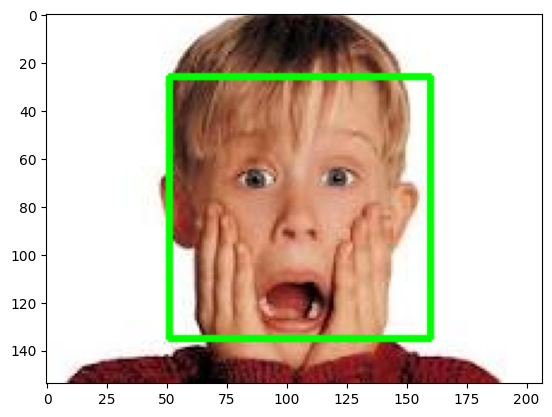

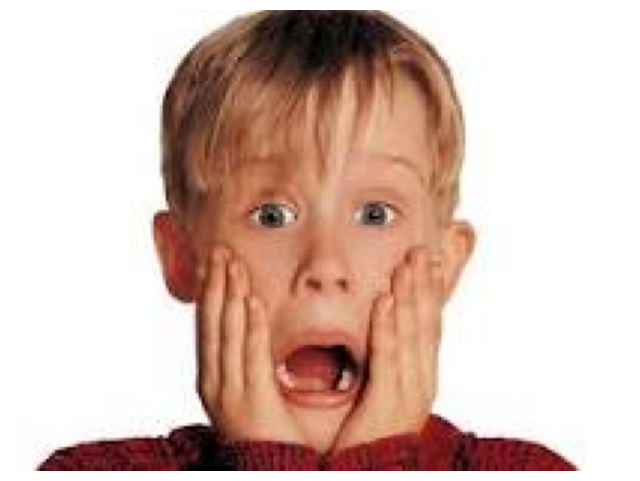

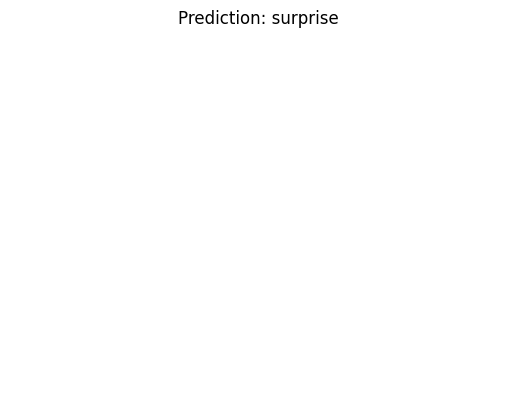


******** Recommended Music ********



name                  artist  \
0  A Boy Brushed Red Living In Black And White               Underoath   
1                          A Place for My Head             Linkin Park   
2                                       ATTACK  Thirty Seconds To Mars   
3                           Adagio For Strings           Lucas & Steve   
4                            Afraid of Heights            Billy Talent   

        mood  
0  Energetic  
1  Energetic  
2  Energetic  
3  Energetic  
4  Energetic

In [104]:
pred_and_plot("/kaggle/input/final-predict/fear surbrise.jpeg", Emotion_Classes, 224)

No Faces Detected
Sentiment Identified as:  sad


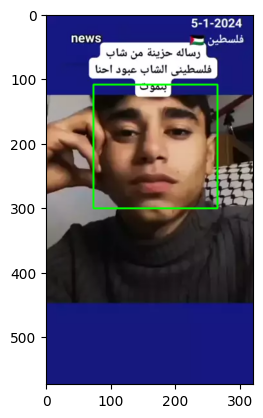

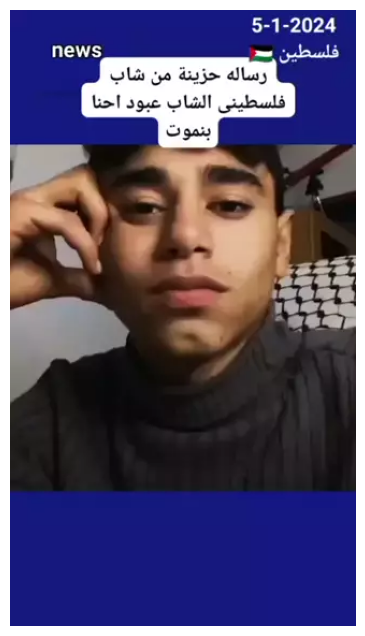

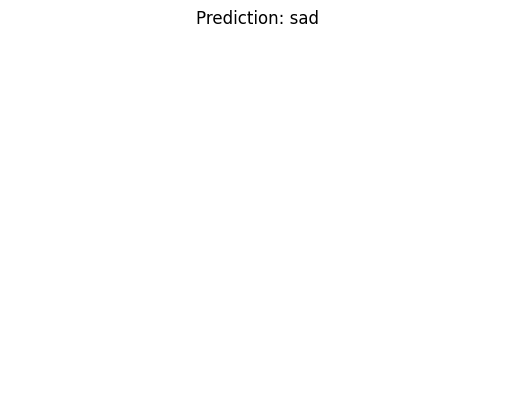


******** Recommended Music ********



name                    artist mood
0           23            Blonde Redhead  Sad
1     9 Crimes               Damien Rice  Sad
2  Algo Rhythm  One Sentence. Supervisor  Sad
3       Alison                  Slowdive  Sad
4   All I Want                  Kodaline  Sad

In [105]:
pred_and_plot("/kaggle/input/final-predict/saddd aboud.webp", Emotion_Classes, 224)

Sentiment Identified as:  sad


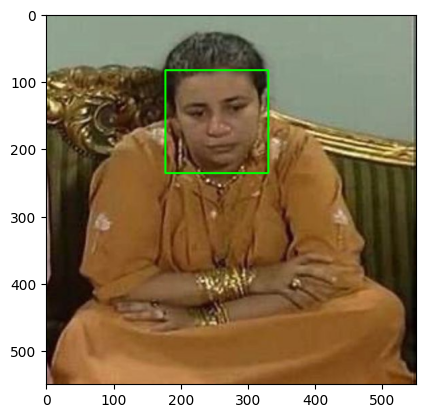

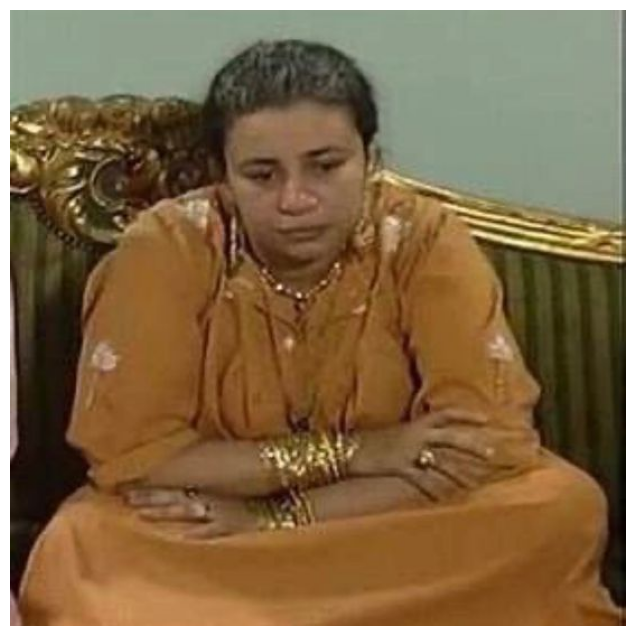

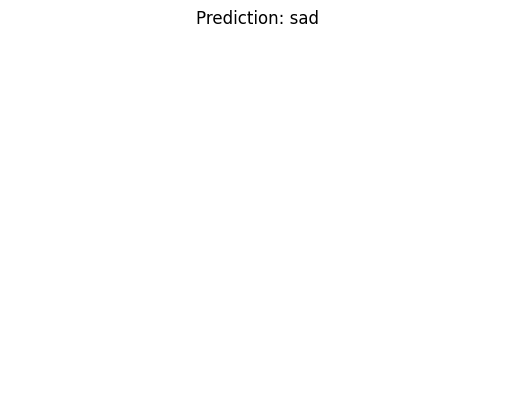


******** Recommended Music ********



name                    artist mood
0           23            Blonde Redhead  Sad
1     9 Crimes               Damien Rice  Sad
2  Algo Rhythm  One Sentence. Supervisor  Sad
3       Alison                  Slowdive  Sad
4   All I Want                  Kodaline  Sad

In [106]:
pred_and_plot("/kaggle/input/final-predict/sdddddddddddddddddddd.jpg", Emotion_Classes, 224)

Sentiment Identified as:  surprise


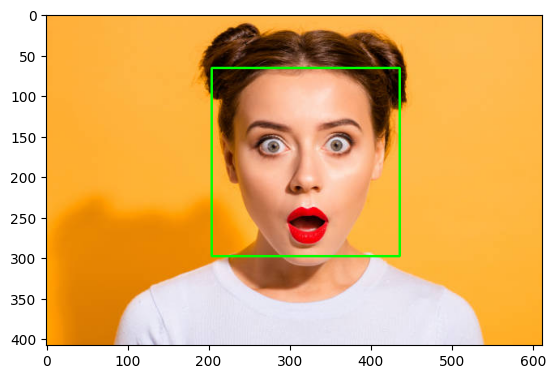

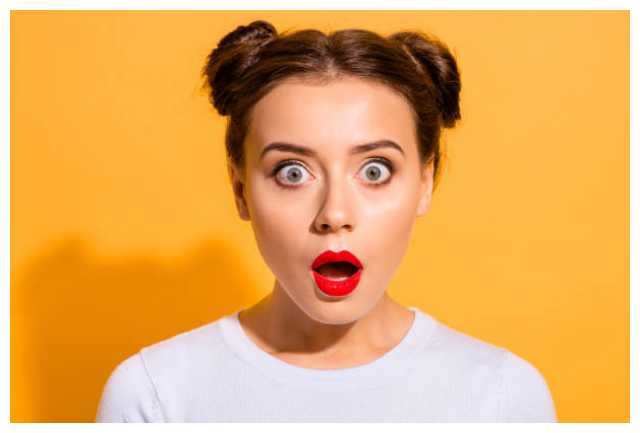

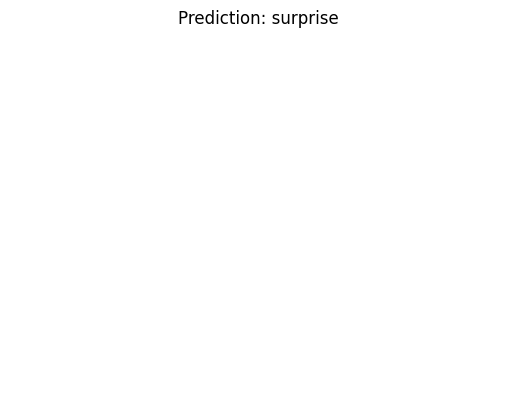


******** Recommended Music ********



name                  artist  \
0  A Boy Brushed Red Living In Black And White               Underoath   
1                          A Place for My Head             Linkin Park   
2                                       ATTACK  Thirty Seconds To Mars   
3                           Adagio For Strings           Lucas & Steve   
4                            Afraid of Heights            Billy Talent   

        mood  
0  Energetic  
1  Energetic  
2  Energetic  
3  Energetic  
4  Energetic

In [107]:
pred_and_plot("/kaggle/input/final-predict/surprise.jpg", Emotion_Classes, 224)